<h1 align=center><font size = 8>Data Science Capstone Project</font></h1>
<h1 align=center><font size = 8>A Comparison of Dallas and Fort Worth</font></h1>

## Introduction
<blockquote>It is often said that Dallas is where the east ends and Fort Worth is where the west begins.  Certainly, it is true that when you think of Fort Worth, you think of pickup trucks and cowboy boots and Billy Bob's at The Stockyards and when you think of Dallas, you think of BMW's and banking and Highland Park.  The question for someone who's company has recently moved to the DFW area, though, is:  is there a difference in the neighborhoods in Fort Worth and Dallas?</blockquote>
<blockquote>This project will use Zillow nighborhood data to see if there are any systematic differences in Dallas vs. Fort Worth nighborhoods using k-means clustering.</blockquote>

We will start by loading the libraries that we need for this project.

In [2]:
try:
    import pandas as pd
    import numpy as np
except:
    !conda install -c anaconda pandas numpy --yes 
    import pandas as pd
    import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
try:
    from geopy.geocoders import Nominatim # to convert address into latitude and longitude
except:
    !conda install -c conda-forge geopy --yes 
    from geopy.geocoders import Nominatim
try:
    import folium # plotting library
except:
    !conda install -c conda-forge folium --yes 
    import folium
from bs4 import BeautifulSoup
import urllib.request
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import geojson
!conda activate geo1
from shapely.geometry import Point, Polygon

In [3]:
!conda activate geo1
from shapely.geometry import Point, Polygon

## Data
The geodata used for this project is the Zillow US Neighborhoods dataset.  Zillow makes this data available for free under a creative commons licence.  It can be downloaded at "https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods%40public/export/".
<br>
<br>
We used the export filters and downloaded one geojson file for Fort Worth and a second geojson file for Dallas.  The files contain full geoshape data and has "properties" sections that that contain the city, neighborhood name, regionid, geo_point_2d, county and state.  We parse the files to just load the properties section and append it to a dataframe.  We then split the geo_data_2d entry into Latitude and Longitude columns, dropping any rows where geo_data_2d is NA.


In [4]:
with open('e:/downloads/zillow-neighborhoods-FortWorth.geojson') as json_data:
    fortworth_neighborhood_data = geojson.load(json_data)
with open('e:/downloads/zillow-neighborhoods-Dallas.geojson') as json_data:
    dallas_neighborhood_data = geojson.load(json_data)
print(type(fortworth_neighborhood_data), type(dallas_neighborhood_data))

<class 'geojson.feature.FeatureCollection'> <class 'geojson.feature.FeatureCollection'>


In [5]:
print(type(fortworth_neighborhood_data[0]['geometry']['coordinates'][0]))
print(fortworth_neighborhood_data[0]['geometry']['coordinates'][0])
print(fortworth_neighborhood_data['features'][0])

<class 'list'>
[[-97.428271, 32.645946], [-97.428288, 32.645946], [-97.428367, 32.645944], [-97.428685, 32.645933], [-97.429647, 32.645984], [-97.4302, 32.646044], [-97.430962, 32.646061], [-97.432542, 32.646125], [-97.43244, 32.648147], [-97.428821, 32.648459], [-97.428535, 32.647886], [-97.428396, 32.647557], [-97.428318, 32.647253], [-97.428249, 32.646923], [-97.42824, 32.646541], [-97.428271, 32.645946]]
{"geometry": {"coordinates": [[[-97.428271, 32.645946], [-97.428288, 32.645946], [-97.428367, 32.645944], [-97.428685, 32.645933], [-97.429647, 32.645984], [-97.4302, 32.646044], [-97.430962, 32.646061], [-97.432542, 32.646125], [-97.43244, 32.648147], [-97.428821, 32.648459], [-97.428535, 32.647886], [-97.428396, 32.647557], [-97.428318, 32.647253], [-97.428249, 32.646923], [-97.42824, 32.646541], [-97.428271, 32.645946]]], "type": "Polygon"}, "properties": {"city": "Fort Worth", "county": "Tarrant", "geo_point_2d": [32.64714146486756, -97.43035652827258], "name": "Briercliff", "r

In [6]:
fortworth_neighborhood_data_slice = fortworth_neighborhood_data['features']
df = pd.DataFrame(columns=['city','name','regionid','geo_point_2d','county','state'])
df_coordinates = pd.DataFrame(columns=['coordinates'])
for entry in fortworth_neighborhood_data_slice:
    df = df.append(entry['properties'],ignore_index=True)
    df_coordinates = df_coordinates.append(entry['geometry'],ignore_index=True)
dallas_neighborhood_data_slice = dallas_neighborhood_data['features']
for entry in dallas_neighborhood_data_slice:
    df = df.append(entry['properties'],ignore_index=True)
    df_coordinates = df_coordinates.append(entry['geometry'],ignore_index=True)
df = df.rename(columns={'name': 'Neighborhood'})
df['coordinates']=df_coordinates['coordinates']
df.head()

,city,Neighborhood,regionid,geo_point_2d,county,state,coordinates
0,Fort Worth,Briercliff,422763,"[32.64714146486756, -97.43035652827258]",Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645..."
1,Fort Worth,Fairmount,233172,"[32.724372978687654, -97.33766189387364]",Tarrant,TX,"[[[-97.34377, 32.718042], [-97.34377, 32.71804..."
2,Fort Worth,Willow Creek,207722,"[32.63110091743264, -97.3434603767844]",Tarrant,TX,"[[[-97.348532, 32.634888], [-97.34777, 32.6348..."
3,Fort Worth,Shaw Clarke,422871,"[32.70111450603923, -97.33719612060821]",Tarrant,TX,"[[[-97.33749, 32.70601], [-97.33749, 32.705724..."
4,Fort Worth,Carver Heights,422820,"[32.72505076405124, -97.22932078449055]",Tarrant,TX,"[[[-97.228473, 32.725718], [-97.228222, 32.725..."


Split up geo_point_2d into Latitude and Longitude

In [7]:
print(df.shape)
df = df.dropna(subset=['geo_point_2d'])
print(df.shape)
df2 = pd.DataFrame(df["geo_point_2d"].tolist(), columns=['Latitude','Longitude']) #pd.DataFrame(df['geo_point_2d'].tolist(),index=df.index)
df = pd.concat([df, df2], axis=1)
df.drop(['geo_point_2d'],axis=1,inplace=True)
df.head()

(425, 7)
(425, 7)


,city,Neighborhood,regionid,county,state,coordinates,Latitude,Longitude
0,Fort Worth,Briercliff,422763,Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645...",32.647141,-97.430357
1,Fort Worth,Fairmount,233172,Tarrant,TX,"[[[-97.34377, 32.718042], [-97.34377, 32.71804...",32.724373,-97.337662
2,Fort Worth,Willow Creek,207722,Tarrant,TX,"[[[-97.348532, 32.634888], [-97.34777, 32.6348...",32.631101,-97.343460
3,Fort Worth,Shaw Clarke,422871,Tarrant,TX,"[[[-97.33749, 32.70601], [-97.33749, 32.705724...",32.701115,-97.337196
4,Fort Worth,Carver Heights,422820,Tarrant,TX,"[[[-97.228473, 32.725718], [-97.228222, 32.725...",32.725051,-97.229321


In [8]:
# load zillow home prices
home_prices = pd.read_csv('Neighborhood_Zhvi_AllHomes.csv')
print(home_prices.shape)
df['regionid'] = df['regionid'].astype('int')
print(type(df['regionid'][0]))
home_prices = pd.merge(df,home_prices, left_on='regionid', right_on='RegionID', how='left')
home_prices.head()
#dfw_venues.head()

(16147, 301)
<class 'numpy.int32'>


,city,Neighborhood,regionid,county,state,coordinates,Latitude,Longitude,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
0,Fort Worth,Briercliff,422763,Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645...",32.647141,-97.430357,422763.0,16533.0,Briercliff,Neighborhood,TX,TX,Fort Worth,Dallas-Fort Worth-Arlington,Tarrant County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277005.0,275131.0,273246.0,269484.0,266984.0,264742.0,263505.0,261248.0,259602.0,258853.0,260550.0,262156.0,263092.0,263038.0,263664.0,265627.0,267315.0,269675.0,270991.0,274175.0,27

Extract Dallas-Fort Worth

In [9]:
#dfw = df[df['city'].isin(['Dallas', 'Fort Worth'])]
dfw = df.copy()
dfw.drop(['regionid'],axis=1,inplace=True)
dfw.sort_values(['city','Neighborhood'], inplace=True, ignore_index=True)
print(dfw.shape)
dfw.groupby("city").count()

(425, 7)


,Neighborhood,county,state,coordinates,Latitude,Longitude
city,,,,,,
Carrollton,21,21,21,21,21,21
Dallas,34,34,34,34,34,34
Desoto,6,6,6,6,6,6
Fort Worth,225,225,225,225,225,225
Garland,85,85,85,85,85,85
Irving,18,18,18,18,18,18
Mesquite,4,4,4,4,4,4
Plano,1,1,1,1,1,1
Richardson,31,31,31,31,31,31


# Methodology
##  Visual Inspection:  Create a map of DFW Neighborhoods

In [10]:
# create map - use Arlington for map lat/long
address = 'Arlington, TX'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Arlington are {}, {}.'.format(latitude, longitude))
# using point slightly north to get centering right
latitude =32.791825
longitude = -97.03

The geograpical coordinate of Arlington are 32.701938999999996, -97.10562379033699.


In [11]:
# create map of DFW using latitude and longitude values for Arlington
map_dfw = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=True)

# add markers to map
for lat, lng, city, neighborhood in zip(dfw['Latitude'], dfw['Longitude'], dfw['city'], dfw['Neighborhood']):
    label = '{}, {}, {}, {}'.format(neighborhood, city, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dfw)  
map_dfw.save('DFW_Neighborhoods.html')  
map_dfw

# Get Neighborhood Venues

In [12]:
CLIENT_ID = 'YPF4NY2VJMYEMROHWYBYVI11IZKQ0H4EDECKGJR0XDYRWE4M' # your Foursquare ID
CLIENT_SECRET = 'LI202HN0RHIHWIIQQPWSYIPUQE14DLGSNALI21B5XGV4E31Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1200 #1600 approx 1 mile, 500 approx .3 mile

In [13]:
def getVenuesInPolygon(names, latitudes, longitudes, polygons):
    file_handle=open('coordinates.csv','w')
    radius=8000
    venues_list=[]
    for name, lat, lng, poly in zip(names, latitudes, longitudes, polygons):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #try:    
        # make the GET request
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        results = requests.get(url).json()["response"]
        if len(results)>0:
            results = results['groups'][0]['items']
            while len(poly)>0 and len(poly)<3:
                poly = poly[0]
            try:
                coordinates = Polygon(poly)
            except:
                try:
                    coordinates = Polygon(poly[0])
                except:
                    try:
                        coordinates = Polygon(poly[0][0])
                    except:
                        print(name," Invalid coordinates: length: ",len(poly),' coordinates: ', poly)
                        file_handle.write(name," Invalid coordinates: length: ",len(poly),' coordinates: ')
                        file_handle.write(poly)            
            # return only relevant information for each nearby venue
            #print(results)
            venue_count = 0
            for v in results:
                pt = Point([v['venue']['location']['lng'],v['venue']['location']['lat']])
                #if (coordinates.length>0 and pt.within(coordinates)) or (coordinates.length==0 and v['venue']['location']['distance']<800):
                if (coordinates.length>0 and pt.within(coordinates)) or v['venue']['location']['distance']<800:
                    venue_count = venue_count + 1
                    #print(pt,' inside ',coordinates)
                    venues_list.append([name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
                        v['venue']['categories'][0]['name']])
                #else:
                #    print(pt,' outside ',coordinates)
            print(name, lat, lng, ' venue count ', venue_count)            
            if venue_count==0:
                print('\tno venues')
                venues_list.append([
                    name, 
                lat, 
                    lng, 
                    'Residential', 
                    lat, 
                    lng,  
                    'Residential'
                    ])
            
        else:
            print(name, lat, lng,' No groups in results')
            venues_list.append([
                    name, 
                    lat, 
                    lng, 
                    'Residential', 
                    lat, 
                    lng,  
                    'Residential'
                    ])
                  
        #except:
        #    print('\tProblem getting info')
    #print('venues_list:  ',venues_list)  
    nearby_venues = pd.DataFrame(venues_list, columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 
        'Venue Longitude', 'Venue Category']) 
    #nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    #nearby_venues = pd.DataFrame(columns = ['Neighborhood', 
    #              'Neighborhood Latitude', 
    #              'Neighborhood Longitude', 
    #              'Venue', 
    #              'Venue Latitude', 
    #              'Venue Longitude', 
    #              'Venue Category'])
    file_handle.close()
    return(nearby_venues)

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('\tProblem getting info')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
#dfw_venues = getNearbyVenues(names=dfw['Neighborhood'],latitudes=dfw['Latitude'],longitudes=dfw['Longitude'],radius)
#print(dfw['coordinates'].iloc[:5])
radius=3200
#dfw_venues = getVenuesInPolygon(names=dfw['Neighborhood'].iloc[:5],latitudes=dfw['Latitude'].iloc[:5],longitudes=dfw['Longitude'].iloc[:5],
#    polygons=dfw['coordinates'].iloc[:5])
dfw_venues = getVenuesInPolygon(names=dfw['Neighborhood'],latitudes=dfw['Latitude'],longitudes=dfw['Longitude'],polygons=dfw['coordinates'])
#print (dfw_venues.head())
print('There are {} unique categories.'.format(len(dfw_venues['Venue Category'].unique())))

Bel Air of Josey Ranch 32.969355914257726 -96.88168631227494  venue count  0
	no venues
Cambridge Estates 32.988927644291394 -96.91617820375673  venue count  10
Carrollton Heights 32.956817736977484 -96.90127455361676  venue count  3
Carrollton Summertree 32.97278590625278 -96.86834792754553  venue count  1
Carrolton Highlands 32.951421190068444 -96.89745971865148  venue count  0
	no venues
Hill'n Dale 32.9652324227805 -96.89314077922661  venue count  0
	no venues
Jackson Arms 32.97657242364724 -96.89296428247056  venue count  1
Mcoy Estates 32.98105765762574 -96.89554645640186  venue count  2
Morningside 32.98840829897419 -96.87152296182454  venue count  0
	no venues
Nob Hill 32.98963477794778 -96.89570633349281  venue count  1
Oak Tree North 32.98817469682512 -96.86008121492931  venue count  2
Park Terrace 32.96294828979307 -96.9049947817715  venue count  0
	no venues
Parks of Carrollton 32.97653456989962 -96.9022608953078  venue count  6
Parkside Estates 32.97768723189802 -96.872023

In [16]:
dfw_venues.loc[dfw_venues['Venue Category']=='Zoo Exhibit']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
94,Cedar Crest,32.71831,-96.788708,Dallas Zoological Society,32.740868,-96.814195,Zoo Exhibit


In [17]:
# load and merge Venue Groups
venue_groups = pd.read_csv('VenueGroups.csv')
venue_groups.head()
if 'Venue Group' in dfw_venues.columns:
    dfw_venues.drop('Venue Group',axis=1, inplace=True)
dfw_venues = dfw_venues.join(venue_groups.set_index('Venue Category'), on='Venue Category')
dfw_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
0,Bel Air of Josey Ranch,32.969356,-96.881686,Residential,32.969356,-96.881686,Residential,Residential
1,Cambridge Estates,32.988928,-96.916178,Super H-Mart,32.984990,-96.911966,Supermarket,Grocery Store
2,Cambridge Estates,32.988928,-96.916178,Chick-fil-A,32.986170,-96.909283,Fast Food Restaurant,Fast-Food Venue
3,Cambridge Estates,32.988928,-96.916178,Tous Les Jours,32.984917,-96.911973,Bakery,Fast-Food Venue
4,Cambridge Estates,32.988928,-96.916178,I•CE•NY Dallas,32.984423,-96.910279,Ice Cream Shop,Fast-Food Venue


In [18]:
dfw_venues[dfw_venues['Venue Category']=='Discount Store']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
245,Lake Highlands,32.893643,-96.754631,Nordstrom Rack,32.868091,-96.769055,Discount Store,Shopping Venues
395,Northeast Dallas,32.845409,-96.714138,Dollar Tree,32.834805,-96.702150,Discount Store,Shopping Venues
588,Southeast Dallas,32.711816,-96.664079,Dollar General,32.734970,-96.702222,Discount Store,Shopping Venues
591,Southeast Dallas,32.711816,-96.664079,Dollar General,32.747185,-96.647554,Discount Store,Shopping Venues
602,Southeast Dallas,32.711816,-96.664079,Family Dollar,32.735434,-96.650046,Discount Store,Shopping Venues
603,Southeast Dallas,32.711816,-96.664079,Family Dollar,32.738342,-96.684454,Discount Store,Shopping Venues
606,Southeast Dallas,32.711816,-96.664079,Family Dollar,32.712608,-96.684990,Discount Store,Shopping Venues
660,Winnetka Heights,32.736942,-96.893228,Dollar General,32.706146,-96.898775,Discount Store,Shopping Venues
670,Wolf Creek,32.658400,-96.846397,Dollar Tree,32.686501,-96.826845,Discount Store,Shopping Venues
703,Altemesa East,32.646051,-97.282105,Family Dollar,32.649352,-97.283846,Discount Store,Shopping Venues


In [19]:
# make sure all venue categories have been assigned to venue groups
dfw_venues[dfw_venues['Venue Group']=='']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group


In [20]:
# subroutine to write formated dataframe to html
def write_to_html(df, title='', filename='out.html'):
    result = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <title>Capstone Final Project</title>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
    <script src="https://code.jquery.com/jquery-3.4.1.slim.min.js" integrity="sha384-J6qa4849blE2+poT4WnyKhv5vZF5SrPo0iEjwBvKU7imGFAV0wwj1yYfoRSJoZ+n" crossorigin="anonymous"></script>
    <script src="https://cdn.jsdelivr.net/npm/popper.js@1.16.0/dist/umd/popper.min.js" integrity="sha384-Q6E9RHvbIyZFJoft+2mJbHaEWldlvI9IOYy5n3zV9zzTtmI3UksdQRVvoxMfooAo" crossorigin="anonymous"></script>
    
    <!-- Bootstrap CSS  v4 -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.4.1/css/bootstrap.min.css" integrity="sha384-Vkoo8x4CGsO3+Hhxv8T/Q5PaXtkKtu6ug5TOeNV6gBiFeWPGFN9MuhOf23Q9Ifjh" crossorigin="anonymous">
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css">
    <script src="https://stackpath.bootstrapcdn.com/bootstrap/4.4.1/js/bootstrap.min.js" integrity="sha384-wfSDF2E50Y2D1uUdj0O3uMBJnjuUD4Ih7YwaYd1iqfktj0Uod8GCExl3Og8ifwB6" crossorigin="anonymous"></script>
    
	<link rel="stylesheet" href="css/style.css">
</head>
<body>
    '''
    result += '<h2 class="text-center"> %s </h2>\n' % title
    #if type(df) == pd.io.formats.style.Styler:
    #    result += df.render()
    #else:
    result += df.to_html(index=False, justify="center",classes="table table-bordered small mx_auto",escape=False)
    result += '''
</body>
</html>
'''
    with open(filename, 'w') as f:
        f.write(result)

In [21]:
# write venue groups to html file
fname = "VenueGroups.html"
title = "Venue Groups"
write_to_html(venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']), title, fname)
#with  open(fname,"w") as file_handle:
#    file_handle.write(venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']).to_html())
#venue_groups.head()
#venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']).head()

AttributeError: module 'pandas.io.formats' has no attribute 'style'

In [22]:
print(dfw_venues.groupby('Neighborhood').count())

Neighborhood Latitude  \
Neighborhood                                               
Alamo Heights                                          6   
Alexandra Meadows                                      1   
Almeta,Bonita, Bella Vista                             1   
Altemesa East                                          2   
Apollo Arapaho & Camelot                               1   
Arapaho                                                1   
Arbor Creek                                            1   
Arcadia Park                                           1   
Arlington Heights                                      7   
Arts District                                         22   
Avondale                                               8   
Bal Harbour                                            1   
Basswood Park                                          3   
Basswood Village                                       1   
Bear Creek                                             8   
Beechwood Creek

# Analyze Neighborhoods

In [23]:
# one hot encoding
dfw_onehot = pd.get_dummies(dfw_venues[['Venue Category']], prefix="", prefix_sep="")
# There is Neighborhood in the venue categories, so we drop that column
try:
    del dfw_onehot['Neighborhood']
except:
    print('No venues called Neighborhood')
# add neighborhood column back to dataframe
dfw_onehot['Neighborhood'] = dfw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfw_onehot.columns[-1]] + list(dfw_onehot.columns[:-1])
dfw_onehot = dfw_onehot[fixed_columns]
dfw_onehot.head()

,Neighborhood,Airport Service,American Restaurant,Arcade,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Butcher,Café,Cajun / Creole Restaurant,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Country Dance Club,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Herbs & Spices Store,High School,History Museum,Hockey Rink,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Movie Theater,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential,Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bel Air of Josey Ranch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Cambridge Estates,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Cambridge Estates,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Cambridge Estates,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [24]:
dfw_grouped = dfw_onehot.groupby('Neighborhood').mean().reset_index()
dfw_grouped.head()

,Neighborhood,Airport Service,American Restaurant,Arcade,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Butcher,Café,Cajun / Creole Restaurant,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Country Dance Club,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Herbs & Spices Store,High School,History Museum,Hockey Rink,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Movie Theater,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential,Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alamo Heights,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alexandra Meadows,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# Group most common venues in each neighborhood

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
top_venue_columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        top_venue_columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venue_columns.append('{}th Most Common Venue'.format(ind+1))
#define similar function for top venues by cluster
def return_most_common_venues_bycluster(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues_by_cluster = 5

# create columns according to number of top venues by cluster
top_venue_columns_bycluster = ['Cluster']
for ind in np.arange(num_top_venues_by_cluster):
    try:
        top_venue_columns_bycluster.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venue_columns_bycluster.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=top_venue_columns)
neighborhoods_venues_sorted['Neighborhood'] = dfw_grouped['Neighborhood']

for ind in np.arange(dfw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dfw_grouped.iloc[ind, :], num_top_venues)
    for col in range(num_top_venues):
        if dfw_grouped.set_index('Neighborhood').loc[[neighborhoods_venues_sorted.iloc[ind, 0]],[neighborhoods_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            neighborhoods_venues_sorted.iloc[ind, 1+col] = 'NA'
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Heights,Dessert Shop,Diner,Sushi Restaurant,BBQ Joint,Grocery Store,Coffee Shop,NA,NA,NA,NA
1,Alexandra Meadows,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,"Almeta,Bonita, Bella Vista",Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Altemesa East,Discount Store,Cosmetics Shop,NA,NA,NA,NA,NA,NA,NA,NA
4,Apollo Arapaho & Camelot,Butcher,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [26]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 6

dfw_grouped_clustering = dfw_grouped.drop('Neighborhood', axis=1)
if 'Cluster' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop('Cluster',axis=1, inplace=True)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfw_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
dfw_merged = dfw.copy()

# merge merge with venues to add latitude/longitude for each neighborhood
dfw_merged = dfw_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dfw_merged.head()

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,Dallas,TX,"[[[-96.884675, 32.967425], [-96.884703, 32.969...",32.969356,-96.881686,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,Carrollton,Cambridge Estates,Dallas,TX,"[[[-96.913294, 32.990296], [-96.910004, 32.990...",32.988928,-96.916178,5,Bakery,Supermarket,Indian Restaurant,Korean Restaurant,Ice Cream Shop,Asian Restaurant,Bubble Tea Shop,Seafood Restaurant,Fast Food Restaurant,NA
2,Carrollton,Carrollton Heights,Dallas,TX,"[[[-96.906652, 32.955414], [-96.906635, 32.956...",32.956818,-96.901275,5,American Restaurant,Brewery,Southern / Soul Food Restaurant,NA,NA,NA,NA,NA,NA,NA
3,Carrollton,Carrollton Summertree,Dallas,TX,"[[[-96.864348, 32.97025], [-96.867828, 32.9702...",32.972786,-96.868348,1,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,Dallas,TX,"[[[-96.890407, 32.95367], [-96.890393, 32.9496...",32.951421,-96.897460,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


## check for invalid cluster labels

In [27]:
idx = pd.to_numeric(dfw_merged['Cluster'], errors='coerce').isna()
print('Number of neighborhoods with invalid Clusters: ',len(dfw_merged[idx]), ' out of ',len(dfw_merged.index))
#neighborhoods_venues_sorted[idx]

dfw_merged[idx]

Number of neighborhoods with invalid Clusters:  0  out of  425


,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Map clusters--removing rows with invalid cluster labels and converting cluster labels to int before we map them

In [28]:

# first, we have to drop non-numeric clusters and change them to int
dfw_merged = dfw_merged[pd.to_numeric(dfw_merged['Cluster'], errors='coerce').notnull()]
dfw_merged['Cluster'] = dfw_merged['Cluster'].astype('int')
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10,control_scale=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow2=['#0000ff','#800080','#ff964f','#ff0000','#008000','#ffd700','#1996f3','#663300','#ffc0cb','#daa520','#ff00ff','#9efd38','#808000','#008080','#800000','#000080'] 
rainbow_text=['blue','purple','orange','red','green','yellow','sky blue','brown','pink','gold','fuchsia','lime','olive','teal','maroon','navy']
#create a dataframe to be used later
color_df = pd.DataFrame(rainbow_text)
color_df.columns = ['Color']
color_df['Cluster'] = color_df.index
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfw_merged['Latitude'], dfw_merged['Longitude'], dfw_merged['Neighborhood'], dfw_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow2[cluster],
        fill=True,
        fill_color=rainbow2[cluster],
        fill_opacity=0.7).add_to(map_clusters)
title_html = '''
            <h3 align="center" style="font-size:20px"><b>DFW Neighborhoods by Venue Category</b></h3>
            '''
map_clusters.get_root().html.add_child(folium.Element(title_html))
map_clusters.save('DFW_by_VenueCategory.html') 
map_clusters

## Examine cluster composition

In [29]:
dfw_merged.groupby('Cluster').count()

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster,,,,,,,,,,,,,,,,,
0,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182
1,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
2,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
4,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
5,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192


In [30]:
# create a dataframe to store information about the clusters
clusters_by_category = pd.DataFrame(dfw_merged.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
clusters_by_category.columns = ['Count By Group']
clusters_by_category = clusters_by_category.merge(color_df, left_index=True, right_index=True)
#del cluster_count['Cluster']
# get count by cluster and merge
df = pd.DataFrame(dfw_merged.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
df.columns = ['Num']
clusters_by_category = clusters_by_category.merge(df, left_index=True, right_index=True)
clusters_by_category = clusters_by_category[['Cluster','Color', 'Num']]

clusters_by_category

,Cluster,Color,Neighborhoods
0,0,blue,182
1,1,purple,29
2,2,orange,6
3,3,red,7
4,4,green,9
5,5,yellow,192


In [ ]:
def get_top_venues_w_pcnt(row, num_top_venues, first_col):
    df = pd.DataFrame(row.iloc[first_col:].sort_values(ascending=False))
    df.columns = ['Pcnt']
    df['Pcnt'] = pd.Series(["{0:.0f}%".format(val*100) for val in df['Pcnt']],index = df.index)
    df['Venue-Pcnt'] = df.index.map(str) + '-' + df['Pcnt'].map(str)
    df.loc[df.Pcnt == '0%','Venue-Pcnt'] = ''
    #print(df)
    return df['Venue-Pcnt'].values[0:num_top_venues]

In [31]:
# get most common venues by cluster
venues_bycluster = dfw_venues.copy()
venues_bycluster = pd.merge(venues_bycluster, dfw_merged[['Neighborhood', 'Cluster']], on='Neighborhood', how='outer', indicator=False)
venues_bycluster = venues_bycluster[[venues_bycluster.columns[-1]] + list(venues_bycluster.columns[:-1])]
venues_bycluster.head()
# one hot encoding
cluster_onehot = pd.get_dummies(venues_bycluster[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
cluster_onehot['Cluster'] = venues_bycluster['Cluster'] 
# move neighborhood column to the first column
fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
cluster_onehot = cluster_onehot[fixed_columns]
group_bycluster = cluster_onehot.groupby('Cluster').mean().reset_index()
cluster_venues_sorted = pd.DataFrame(columns=top_venue_columns_bycluster)
cluster_venues_sorted['Cluster'] = group_bycluster['Cluster']
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues_bycluster(group_bycluster.iloc[ind, :], num_top_venues_by_cluster)
    for col in range(num_top_venues_by_cluster):
        if group_bycluster.set_index('Cluster').loc[[cluster_venues_sorted.iloc[ind, 0]],[cluster_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            cluster_venues_sorted.iloc[ind, 1+col] = ''
#group_bycluster.head()
cluster_venues_sorted.head(15)


,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Residential,Skating Rink,,,
1,1,Pharmacy,Park,American Restaurant,Convenience Store,Italian Restaurant
2,2,Mexican Restaurant,,,,
3,3,Golf Course,Italian Restaurant,,,
4,4,Discount Store,Cosmetics Shop,Fried Chicken Joint,Gym / Fitness Center,Pharmacy
5,5,Mexican Restaurant,Burger Joint,Fast Food Restaurant,Coffee Shop,Grocery Store


In [33]:
# get the average percentage of the groups by cluster
dfw_clustering_bycategory =dfw_grouped.copy()
# add clustering labels
dfw_clustering_bycategory.insert(0, 'Cluster', kmeans.labels_)
dfw_clustering_bycategory = dfw_clustering_bycategory.groupby('Cluster').mean()
average_venues_by_cluster = pd.DataFrame(columns=top_venue_columns_bycluster)
average_venues_by_cluster['Cluster'] = group_bycluster['Cluster']
# get top groups
for ind in np.arange(dfw_clustering_bycategory.shape[0]):
    average_venues_by_cluster.iloc[ind, 1:] = get_top_venues_w_pcnt(dfw_clustering_bycategory.iloc[ind, :], num_top_venues_by_cluster,1)
average_venues_by_cluster

NameError: name 'get_top_venues_w_pcnt' is not defined

In [34]:
# join tables
clusters_by_category = clusters_by_category.join(average_venues_by_cluster.set_index('Cluster'), on='Cluster')
# add link to cluster listings and save file
clusters_by_category['List'] = clusters_by_category.apply(lambda row: '<a href="Cluster-ByCategory-' + str(row.Cluster) + '-' + str(kclusters) + '.html"'  + 'target="_blank">Cluster ' + str(row.Cluster) + '</a>',axis=1)
fname = "Clusters_By_Category.html"
title = 'Clusters By Category'
write_to_html(clusters_by_category,title,fname)
#with  open(fname,"w") as file_handle:
#        file_handle.write(clusters_by_category.to_html(index=False, justify="center",classes="table table-bordered",escape=False))


AttributeError: module 'pandas.io.formats' has no attribute 'style'

In [35]:
clusters_by_category

,Cluster,Color,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Neighborhood List
0,0,blue,182,NaN,NaN,NaN,NaN,NaN,"<a href=""Cluster-ByCategory-0-6.html""target=""_..."
1,1,purple,29,NaN,NaN,NaN,NaN,NaN,"<a href=""Cluster-ByCategory-1-6.html""target=""_..."
2,2,orange,6,NaN,NaN,NaN,NaN,NaN,"<a href=""Cluster-ByCategory-2-6.html""target=""_..."
3,3,red,7,NaN,NaN,NaN,NaN,NaN,"<a href=""Cluster-ByCategory-3-6.html""target=""_..."
4,4,green,9,NaN,NaN,NaN,NaN,NaN,"<a href=""Cluster-ByCategory-4-6.html""target=""_..."
5,5,yellow,192,NaN,NaN,NaN,NaN,NaN,"<a href=""Cluster-ByCategory-5-6.html""target=""_..."


In [36]:
# write clusters to html files
for f in range(kclusters):
    fname = "Cluster-ByCategory-" + str(f) + "-" + str(kclusters) + ".html"
    title = "Cluster By Category: " +str(f) + " of " + str(kclusters)
    fst_venue_col = 7
    cluster_df = dfw_merged.loc[dfw_merged['Cluster'] == f, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])
    write_to_html(cluster_df, title, fname)
    #with  open(fname,"w") as file_handle:
    #    file_handle.write(cluster_df.to_html())

AttributeError: module 'pandas.io.formats' has no attribute 'style'

In [37]:
dfw_merged.loc[dfw_merged['Neighborhood']=='Wolf Creek']

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Dallas,Wolf Creek,Dallas,TX,"[[[-96.823164, 32.654073], [-96.823078, 32.641...",32.6584,-96.846397,5,Fast Food Restaurant,BBQ Joint,Convenience Store,General Entertainment,Mexican Restaurant,Salon / Barbershop,Pharmacy,Pet Store,Paper / Office Supplies Store,Fried Chicken Joint


In [38]:
dfw_merged.loc[dfw_merged['Cluster'] == 0, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,Carrollton,Hill'n Dale,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,Carrollton,Morningside,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
11,Carrollton,Park Terrace,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
15,Carrollton,Rollingwood Estates,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
19,Carrollton,Whitlock Warriors,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
28,Dallas,Dells District,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
56,Desoto,Candel Meadow,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
57,Desoto,Frost farms,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [39]:
dfw_merged.loc[dfw_merged['Cluster'] == 1, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Carrollton,Carrollton Summertree,1,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
13,Carrollton,Parkside Estates,1,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
20,Carrollton,Woodcreek,1,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
23,Dallas,Buckner Terrace,1,Pharmacy,NA,NA,NA,NA,NA,NA,NA,NA,NA
33,Dallas,Five Mile Creek,1,American Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
68,Fort Worth,Basswood Village,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
132,Fort Worth,Fox Run,1,Pharmacy,NA,NA,NA,NA,NA,NA,NA,NA,NA
134,Fort Worth,Garden Acres,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
151,Fort Worth,Highland Hills,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
181,Fort Worth,Mitchell Boulevard,1,Wings Joint,Park,NA,NA,NA,NA,NA,NA,NA,NA


In [40]:
dfw_merged.loc[dfw_merged['Cluster'] == 2, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
174,Fort Worth,Marine Park,2,Mexican Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
230,Fort Worth,Shaw Clarke,2,Mexican Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
233,Fort Worth,South Hemphill Heights,2,Mexican Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
347,Garland,Place One,2,Mexican Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
361,Garland,Town North Village,2,Mexican Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
409,Richardson,North College Park,2,Mexican Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [41]:
dfw_merged.loc[dfw_merged['Cluster'] == 3, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
102,Fort Worth,Colonial Hills,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
170,Fort Worth,Lost Creek,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
179,Fort Worth,Mira Vista,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
264,Fort Worth,University West,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
279,Fort Worth,Westland,3,Italian Restaurant,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA
321,Garland,Greens,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
350,Garland,Retreat at Firewheel,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [42]:
dfw_merged.loc[dfw_merged['Cluster'] == 4, dfw_merged.columns[[0,1] + list(range(6, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Fort Worth,Altemesa East,-97.282105,4,Discount Store,Cosmetics Shop,NA,NA,NA,NA,NA,NA,NA,NA
116,Fort Worth,Eastland,-97.268136,4,Pharmacy,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA
117,Fort Worth,Eastwood Pleasant Glade,-97.261124,4,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
125,Fort Worth,Falcon Ridge,-97.492986,4,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
141,Fort Worth,Hamlet,-97.284494,4,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
193,Fort Worth,Oakridge Terrace,-97.303970,4,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
303,Garland,Creek Valley,-96.612249,4,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
335,Garland,Monica Park Heights,-96.619582,4,Discount Store,Gym / Fitness Center,NA,NA,NA,NA,NA,NA,NA,NA
370,Garland,Wykeham TownHomes,-96.617290,4,Discount Store,Fried Chicken Joint,NA,NA,NA,NA,NA,NA,NA,NA


In [43]:
dfw_merged.loc[dfw_merged['Cluster'] == 5, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Carrollton,Cambridge Estates,5,Bakery,Supermarket,Indian Restaurant,Korean Restaurant,Ice Cream Shop,Asian Restaurant,Bubble Tea Shop,Seafood Restaurant,Fast Food Restaurant,NA
2,Carrollton,Carrollton Heights,5,American Restaurant,Brewery,Southern / Soul Food Restaurant,NA,NA,NA,NA,NA,NA,NA
6,Carrollton,Jackson Arms,5,Ice Cream Shop,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,Carrollton,Mcoy Estates,5,Sandwich Place,Coffee Shop,NA,NA,NA,NA,NA,NA,NA,NA
9,Carrollton,Nob Hill,5,Sandwich Place,NA,NA,NA,NA,NA,NA,NA,NA,NA
10,Carrollton,Oak Tree North,5,Mexican Restaurant,Gym,NA,NA,NA,NA,NA,NA,NA,NA
12,Carrollton,Parks of Carrollton,5,Ramen Restaurant,Bakery,Supermarket,Bookstore,Market,Bubble Tea Shop,NA,NA,NA,NA
14,Carrollton,Rohton Park,5,Thai Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
16,Carrollton,Savoy of Josey Ranch,5,Ice Cream Shop,NA,NA,NA,NA,NA,NA,NA,NA,NA
17,Carrollton,Trinity Mills,5,Burger Joint,Korean Restaurant,Market,Bubble Tea Shop,Supermarket,Sushi Restaurant,Thai Restaurant,Bookstore,Sandwich Place,Ramen Restaurant


In [44]:
dfw_merged.loc[dfw_merged['Cluster'] == 6, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [45]:
dfw_merged.loc[dfw_merged['Cluster'] == 7, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Analyze Neighborhoods by Venue Group

In [46]:
# one hot encoding
dfw_onehot = pd.get_dummies(dfw_venues[['Venue Group']], prefix="", prefix_sep="")
# There is Neighborhood in the venue categories, so we drop that column
try:
    del dfw_onehot['Neighborhood']
except:
    print('No venues called Neighborhood')
# add neighborhood column back to dataframe
dfw_onehot['Neighborhood'] = dfw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfw_onehot.columns[-1]] + list(dfw_onehot.columns[:-1])
dfw_onehot = dfw_onehot[fixed_columns]
dfw_grouped2 = dfw_onehot.groupby('Neighborhood').mean().reset_index()
neighborhoods_venues_sorted = pd.DataFrame(columns=top_venue_columns)
neighborhoods_venues_sorted['Neighborhood'] = dfw_grouped2['Neighborhood']

for ind in np.arange(dfw_grouped2.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dfw_grouped2.iloc[ind, :], num_top_venues)
    for col in range(num_top_venues):
        if dfw_grouped2.set_index('Neighborhood').loc[[neighborhoods_venues_sorted.iloc[ind, 0]],[neighborhoods_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            neighborhoods_venues_sorted.iloc[ind, 1+col] = 'NA'
# cluster analysis
dfw_grouped_clustering_bygroup = dfw_grouped2.drop('Neighborhood', axis=1)
if 'Cluster' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop('Cluster',axis=1, inplace=True)
# run k-means clustering
kclusters2 = 15
kmeans = KMeans(n_clusters=kclusters2, random_state=0).fit(dfw_grouped_clustering_bygroup)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
dfw_merged_bygroup = dfw.copy()

# merge dfw data to add latitude/longitude for each neighborhood
dfw_merged_bygroup = dfw_merged_bygroup.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

idx = pd.to_numeric(dfw_merged_bygroup['Cluster'], errors='coerce').isna()
print('Number of neighborhoods with invalid Clusters: ',len(dfw_merged_bygroup[idx]), ' out of ',len(dfw_merged_bygroup.index))
print(neighborhoods_venues_sorted[idx])



No venues called Neighborhood
Number of neighborhoods with invalid Clusters:  0  out of  425
Empty DataFrame
Columns: [Cluster, Neighborhood, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []


In [47]:
# Create the map
# first, we have to drop non-numeric clusters and change them to int
dfw_merged_bygroup = dfw_merged_bygroup[pd.to_numeric(dfw_merged_bygroup['Cluster'], errors='coerce').notnull()]
dfw_merged_bygroup['Cluster'] = dfw_merged_bygroup['Cluster'].astype('int')
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=True)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfw_merged_bygroup['Latitude'], dfw_merged_bygroup['Longitude'], dfw_merged_bygroup['Neighborhood'], dfw_merged_bygroup['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow2[cluster],
        fill=True,
        fill_color=rainbow2[cluster],
        fill_opacity=0.7).add_to(map_clusters2)
title_html = '''
            <h3 align="center" style="font-size:20px"><b>DFW Neighborhoods by Venue Group - ''' + str(kclusters2) + ''' Clusters</b></h3>
            '''
map_clusters2.get_root().html.add_child(folium.Element(title_html))

map_clusters2.save('DFW_by_VenueGroup-' + str(kclusters2) + '.html')      
map_clusters2

## Examine cluster composition

In [48]:
# create a dataframe to store information about the clusters
clusters_by_group = pd.DataFrame(dfw_merged_bygroup.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
clusters_by_group.columns = ['Count By Group']
clusters_by_group = clusters_by_group.merge(color_df, left_index=True, right_index=True)
#del cluster_count['Cluster']
# get count by cluster and merge
df = pd.DataFrame(dfw_merged_bygroup.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
df.columns = ['Num']
clusters_by_group = clusters_by_group.merge(df, left_index=True, right_index=True)
clusters_by_group = clusters_by_group[['Cluster','Color', 'Num']]

clusters_by_group


,Cluster,Color,Neighborhoods
0,0,blue,180
1,1,purple,52
2,2,orange,13
3,3,red,9
4,4,green,8
5,5,yellow,9
6,6,sky blue,76
7,7,brown,28
8,8,pink,4
9,9,gold,10


In [49]:
# get most common venues by cluster
venues_bycluster = dfw_venues.copy()
venues_bycluster = pd.merge(venues_bycluster, dfw_merged_bygroup[['Neighborhood', 'Cluster']], on='Neighborhood', how='outer', indicator=False)
venues_bycluster = venues_bycluster[[venues_bycluster.columns[-1]] + list(venues_bycluster.columns[:-1])]
venues_bycluster.head()
# one hot encoding
cluster_onehot = pd.get_dummies(venues_bycluster[['Venue Group']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
cluster_onehot['Cluster'] = venues_bycluster['Cluster'] 
# move neighborhood column to the first column
fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
cluster_onehot = cluster_onehot[fixed_columns]
group_bycluster = cluster_onehot.groupby('Cluster').mean().reset_index()
cluster_venues_sorted = pd.DataFrame(columns=top_venue_columns_bycluster)
cluster_venues_sorted['Cluster'] = group_bycluster['Cluster']
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues_bycluster(group_bycluster.iloc[ind, :], num_top_venues_by_cluster)
    for col in range(num_top_venues_by_cluster):
        if group_bycluster.set_index('Cluster').loc[[cluster_venues_sorted.iloc[ind, 0]],[cluster_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            cluster_venues_sorted.iloc[ind, 1+col] = ''
#group_bycluster.head()
cluster_venues_sorted.head(15)


,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Residential,,,,
1,1,Fast-Food Venue,American Cuisine,Mexican Cuisine,Drinking Establishment,Asian Cuisine
2,2,Asian Cuisine,Park,American Cuisine,Shopping Venue,Fast-Food Venue
3,3,Mexican Cuisine,Golf Course,Park,Convenience Store,
4,4,Gym,Fast-Food Venue,Mexican Cuisine,Shopping Venues,
5,5,American Cuisine,Park,Mediterranean Cuisine,Outdoor Destination,Liquor Store
6,6,Fast-Food Venue,Mexican Cuisine,Asian Cuisine,American Cuisine,Grocery Store
7,7,Fast-Food Venue,Mexican Cuisine,Convenience Store,,
8,8,Convenience Store,,,,
9,9,Health Services,Shopping Venues,Italian Cuisine,,


In [50]:
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = get_top_venues_w_pcnt(group_bycluster.iloc[ind, :], num_top_venues_by_cluster,2)
cluster_venues_sorted

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Residential-100%,,,,
1,1,Fast-Food Venue-15%,American Cuisine-12%,Mexican Cuisine-9%,Drinking Establishment-6%,Asian Cuisine-5%
2,2,Asian Cuisine-67%,Park-11%,American Cuisine-4%,Shopping Venue-4%,Fast-Food Venue-4%
3,3,Mexican Cuisine-72%,Golf Course-11%,Park-11%,Convenience Store-6%,
4,4,Gym-62%,Fast-Food Venue-15%,Mexican Cuisine-8%,Shopping Venues-8%,
5,5,American Cuisine-69%,Park-8%,Mediterranean Cuisine-8%,Outdoor Destination-8%,Liquor Store-8%
6,6,Fast-Food Venue-34%,Mexican Cuisine-11%,Asian Cuisine-8%,American Cuisine-5%,Grocery Store-4%
7,7,Fast-Food Venue-89%,Mexican Cuisine-7%,Convenience Store-2%,,
8,8,Convenience Store-100%,,,,
9,9,Health Services-89%,Shopping Venues-6%,Italian Cuisine-6%,,


In [51]:
# get the average percentage of the groups by cluster
dfw_clustering_bygroup =dfw_grouped2.copy()
# add clustering labels
dfw_clustering_bygroup.insert(0, 'Cluster', kmeans.labels_)
dfw_clustering_bygroup = dfw_clustering_bygroup.groupby('Cluster').mean()
average_venues_by_cluster = pd.DataFrame(columns=top_venue_columns_bycluster)
average_venues_by_cluster['Cluster'] = group_bycluster['Cluster']
# get top groups
for ind in np.arange(dfw_clustering_bygroup.shape[0]):
    average_venues_by_cluster.iloc[ind, 1:] = get_top_venues_w_pcnt(dfw_clustering_bygroup.iloc[ind, :], num_top_venues_by_cluster,1)
average_venues_by_cluster

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Residential-100%,,,,
1,1,Grocery Store-9%,American Cuisine-9%,Fast-Food Venue-8%,Mexican Cuisine-7%,Italian Cuisine-6%
2,2,Asian Cuisine-74%,Park-9%,American Cuisine-4%,Entertainment Venue-4%,Shopping Venue-3%
3,3,Mexican Cuisine-88%,Convenience Store-6%,Golf Course-3%,Park-3%,
4,4,Gym-69%,Fast-Food Venue-12%,Mexican Cuisine-6%,Shopping Venues-6%,
5,5,American Cuisine-78%,Park-6%,Mediterranean Cuisine-6%,Outdoor Destination-6%,Liquor Store-6%
6,6,Fast-Food Venue-40%,Mexican Cuisine-11%,Grocery Store-6%,Asian Cuisine-6%,American Cuisine-4%
7,7,Fast-Food Venue-95%,Mexican Cuisine-3%,Convenience Store-1%,,
8,8,Convenience Store-100%,,,,
9,9,Health Services-88%,Shopping Venues-6%,Italian Cuisine-6%,,


In [52]:
# add link to cluster listings and save file
clusters_by_group = clusters_by_group.join(average_venues_by_cluster.set_index('Cluster'), on='Cluster')
#clusters_by_group = average_venues_by_cluster # comment out to use average across clusters instead of average by cluster
clusters_by_group['List'] = clusters_by_group.apply(lambda row: '<a href="Cluster-ByGroup-' + str(row.Cluster) + '-' + str(kclusters2) + '.html"'  + 'target="_blank">Cluster ' + str(row.Cluster) + '</a>',axis=1)
fname = "Clusters_By_Group-" + str(kclusters2) + ".html"
title = "Clusters By Group, k=" + str(kclusters2)
write_to_html(clusters_by_group,title,fname)
#with  open(fname,"w") as file_handle:
#    file_handle.write(clusters_by_group.to_html(index=False, justify="center",classes="table table-bordered",escape=False))
clusters_by_group


AttributeError: module 'pandas.io.formats' has no attribute 'style'

In [53]:
clusters_by_group

,Cluster,Color,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Neighborhood List
0,0,blue,180,Residential-100%,,,,,"<a href=""Cluster-ByGroup-0-15.html""target=""_bl..."
1,1,purple,52,Grocery Store-9%,American Cuisine-9%,Fast-Food Venue-8%,Mexican Cuisine-7%,Italian Cuisine-6%,"<a href=""Cluster-ByGroup-1-15.html""target=""_bl..."
2,2,orange,13,Asian Cuisine-74%,Park-9%,American Cuisine-4%,Entertainment Venue-4%,Shopping Venue-3%,"<a href=""Cluster-ByGroup-2-15.html""target=""_bl..."
3,3,red,9,Mexican Cuisine-88%,Convenience Store-6%,Golf Course-3%,Park-3%,,"<a href=""Cluster-ByGroup-3-15.html""target=""_bl..."
4,4,green,8,Gym-69%,Fast-Food Venue-12%,Mexican Cuisine-6%,Shopping Venues-6%,,"<a href=""Cluster-ByGroup-4-15.html""target=""_bl..."
5,5,yellow,9,American Cuisine-78%,Park-6%,Mediterranean Cuisine-6%,Outdoor Destination-6%,Liquor Store-6%,"<a href=""Cluster-ByGroup-5-15.html""target=""_bl..."
6,6,sky blue,76,Fast-Food Venue-40%,Mexican Cuisine-11%,Grocery Store-6%,Asian Cuisine-6%,American Cuisine-4%,"<a href=""Cluster-ByGroup-6-15.html""target=""_bl..."
7,7,brown,28,Fast-Food Venue-95%,Mexican Cuisine-3%,Convenience Store-1%,,,"<a href=""Cluster-ByGroup-7-15.html""target=""_bl..."
8,8,pink,4,Convenience Store-100%,,,,,"<a href=""Cluster-ByGroup-8-15.html""target=""_bl..."
9,9,gold,10,Health Services-88%,Shopping Venues-6%,Italian Cuisine-6%,,,"<a href=""Cluster-ByGroup-9-15.html""target=""_bl..."


In [54]:
# write clusters to html files
for f in range(kclusters2):
    fname = "Cluster-ByGroup-" + str(f) + "-" + str(kclusters2) + ".html"
    title = "Cluster By Group: " + str(f) + " of " + str(kclusters2)
    fst_venue_col = 7
    cluster_df = dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == f, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])
    write_to_html(cluster_df,title,fname)
    #with  open(fname,"w") as file_handle:
    #    file_handle.write(cluster_df.to_html())


AttributeError: module 'pandas.io.formats' has no attribute 'style'

In [55]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 0, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,Carrollton,Hill'n Dale,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,Carrollton,Morningside,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
11,Carrollton,Park Terrace,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
15,Carrollton,Rollingwood Estates,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
19,Carrollton,Whitlock Warriors,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
28,Dallas,Dells District,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
56,Desoto,Candel Meadow,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
57,Desoto,Frost farms,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [56]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 1, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Carrollton,Parks of Carrollton,1,Grocery Store,Bookstore,Bubble Tea Shop,Fast-Food Venue,NA,NA,NA,NA,NA,NA
21,Dallas,Arts District,1,American Cuisine,Fast-Food Venue,Arts/Entertainment,Museum,Mexican Cuisine,Grocery Store,Lodging,Park,Seafood Restaurant,Asian Cuisine
22,Dallas,Bluffview,1,Mexican Cuisine,American Cuisine,Grocery Store,Drinking Establishment,Fast-Food Venue,French Cuisine,Seafood Restaurant,Smoke Shop,Asian Cuisine,Personal Services
25,Dallas,City Center District,1,Arts/Entertainment,Museum,Lodging,Park,American Cuisine,Entertainment Venue,Mexican Cuisine,NA,NA,NA
26,Dallas,Convention Center District,1,Entertainment Venue,American Cuisine,Plaza,Lodging,NA,NA,NA,NA,NA,NA
29,Dallas,Eagle Ford,1,Mexican Cuisine,Fast-Food Venue,Italian Cuisine,Drinking Establishment,Lodging,Outdoor Destination,Event Space,American Cuisine,NA,NA
34,Dallas,Government District,1,Lodging,American Cuisine,Plaza,Fast-Food Venue,Mexican Cuisine,NA,NA,NA,NA,NA
35,Dallas,Lake Caroline,1,Italian Cuisine,Drinking Establishment,Liquor Store,NA,NA,NA,NA,NA,NA,NA
39,Dallas,Main Street District,1,Lodging,Fast-Food Venue,Farmers Market,American Cuisine,Plaza,Mexican Cuisine,Garden Center,NA,NA,NA
40,Dallas,Near East,1,Drinking Establishment,Entertainment Venue,Fast-Food Venue,Lodging,Mexican Cuisine,Seafood Restaurant,American Cuisine,Gas Station,NA,NA


In [57]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 2, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Carrollton,Rohton Park,2,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
76,Fort Worth,Bonnie Brae,2,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
216,Fort Worth,River Trails,2,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
278,Fort Worth,Western Hills North,2,American Cuisine,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
298,Garland,Charleston Commons,2,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
300,Garland,Coomer Creek,2,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
317,Garland,Forest Crest,2,Asian Cuisine,Shopping Venue,NA,NA,NA,NA,NA,NA,NA,NA
357,Garland,The Enclave,2,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
366,Garland,Village Green,2,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
374,Irving,Downtown,2,Asian Cuisine,Park,NA,NA,NA,NA,NA,NA,NA,NA


In [58]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 3, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
174,Fort Worth,Marine Park,3,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
230,Fort Worth,Shaw Clarke,3,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
233,Fort Worth,South Hemphill Heights,3,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
347,Garland,Place One,3,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
353,Garland,Spring Park,3,Mexican Cuisine,Golf Course,Park,NA,NA,NA,NA,NA,NA,NA
361,Garland,Town North Village,3,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
381,Irving,Pioneer,3,Mexican Cuisine,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA
409,Richardson,North College Park,3,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
419,Richardson,Spring Park,3,Mexican Cuisine,Golf Course,Park,NA,NA,NA,NA,NA,NA,NA


In [59]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 4, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Carrollton,Oak Tree North,4,Gym,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
238,Fort Worth,Southgate,4,Gym,NA,NA,NA,NA,NA,NA,NA,NA,NA
248,Fort Worth,Sunset Hills,4,Gym,NA,NA,NA,NA,NA,NA,NA,NA,NA
281,Fort Worth,Westridge Area,4,Gym,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA
316,Garland,First Centerville,4,Gym,NA,NA,NA,NA,NA,NA,NA,NA,NA
318,Garland,Freemonteers,4,Gym,NA,NA,NA,NA,NA,NA,NA,NA,NA
335,Garland,Monica Park Heights,4,Gym,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA
336,Garland,New West,4,Gym,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA


In [60]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 5, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Dallas,Five Mile Creek,5,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
127,Fort Worth,Far Greater Northside,5,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
176,Fort Worth,Meadow Creek,5,American Cuisine,Mediterranean Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
197,Fort Worth,Overton Woods,5,American Cuisine,Outdoor Destination,NA,NA,NA,NA,NA,NA,NA,NA
251,Fort Worth,Tanglewood,5,American Cuisine,Park,NA,NA,NA,NA,NA,NA,NA,NA
254,Fort Worth,The Crossing of Fossil Creek,5,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
340,Garland,Oakridge on the Creek,5,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
345,Garland,Park North,5,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
410,Richardson,Northrich,5,Liquor Store,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA


In [61]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 6, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Carrollton,Cambridge Estates,6,Fast-Food Venue,Asian Cuisine,Bubble Tea Shop,Grocery Store,Seafood Restaurant,NA,NA,NA,NA,NA
17,Carrollton,Trinity Mills,6,Fast-Food Venue,Asian Cuisine,Bookstore,Grocery Store,Bubble Tea Shop,NA,NA,NA,NA,NA
18,Carrollton,Trinity Mills,6,Fast-Food Venue,Asian Cuisine,Bookstore,Grocery Store,Bubble Tea Shop,NA,NA,NA,NA,NA
24,Dallas,Cedar Crest,6,Fast-Food Venue,Zoo Exhibit,Grocery Store,Athletic Venue,Southern / Soul Food Restaurant,NA,NA,NA,NA,NA
27,Dallas,Coppell,6,Seafood Restaurant,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA
30,Dallas,Far North,6,Fast-Food Venue,Asian Cuisine,Mexican Cuisine,American Cuisine,Italian Cuisine,Personal Services,Shopping Venues,Mediterranean Cuisine,Drinking Establishment,Seafood Restaurant
31,Dallas,Far North,6,Fast-Food Venue,Asian Cuisine,Mexican Cuisine,American Cuisine,Italian Cuisine,Personal Services,Shopping Venues,Mediterranean Cuisine,Drinking Establishment,Seafood Restaurant
32,Dallas,Farmers Market District,6,Fast-Food Venue,Drinking Establishment,Farmers Market,Lodging,Asian Cuisine,Garden Center,NA,NA,NA,NA
36,Dallas,Lake Highlands,6,Fast-Food Venue,American Cuisine,Asian Cuisine,Liquor Store,Italian Cuisine,Seafood Restaurant,Golf Course,Home Shop,Motorcycle Shop,Outdoor Destination
38,Dallas,M Streets,6,Fast-Food Venue,Grocery Store,Mexican Cuisine,Asian Cuisine,American Cuisine,Lodging,South American Cuisine,Shopping Venues,Italian Cuisine,NA


In [62]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 7, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Carrollton,Jackson Arms,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,Carrollton,Mcoy Estates,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,Carrollton,Nob Hill,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
16,Carrollton,Savoy of Josey Ranch,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
58,Desoto,Mantle Brook,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
73,Fort Worth,Bluebonnet Hills,7,Fast-Food Venue,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
74,Fort Worth,Bluebonnet Place,7,Fast-Food Venue,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
78,Fort Worth,Brentwood-Oak Hills,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
106,Fort Worth,Coventry Hills,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
112,Fort Worth,Dorado Ranch,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [63]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 8, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Fort Worth,Basswood Village,8,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
134,Fort Worth,Garden Acres,8,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
151,Fort Worth,Highland Hills,8,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
295,Garland,Camelot,8,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [64]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 9, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Dallas,Buckner Terrace,9,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
116,Fort Worth,Eastland,9,Health Services,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA
132,Fort Worth,Fox Run,9,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
227,Fort Worth,Sendera Ranch,9,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
228,Fort Worth,Sendera Ranch,9,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
229,Fort Worth,Sendera Ranch,9,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
237,Fort Worth,South Poly,9,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
242,Fort Worth,Stone Meadow,9,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
268,Fort Worth,Villages of Woodland Springs,9,Italian Cuisine,Health Services,NA,NA,NA,NA,NA,NA,NA,NA
269,Fort Worth,Vista Meadows,9,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [65]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 10, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Fort Worth,Altemesa East,10,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
117,Fort Worth,Eastwood Pleasant Glade,10,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
125,Fort Worth,Falcon Ridge,10,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
141,Fort Worth,Hamlet,10,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
193,Fort Worth,Oakridge Terrace,10,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
208,Fort Worth,Quail Run,10,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
303,Garland,Creek Valley,10,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA


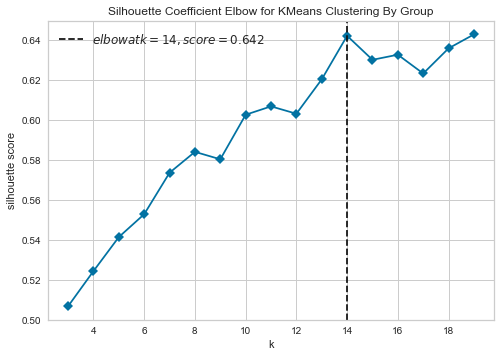

In [66]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
metric_val = 'silhouette'
visualizer = KElbowVisualizer(model, k=(3,20),title="Silhouette Coefficient Elbow for KMeans Clustering By Group", metric=metric_val,timings=False)
# , metric='calinski_harabasz','silhouette'
visualizer.fit(dfw_grouped_clustering_bygroup)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bygroup.png")

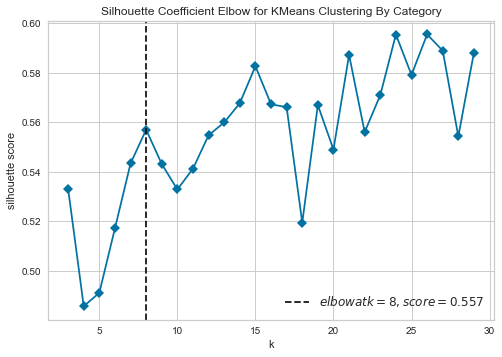

In [67]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,30),title="Silhouette Coefficient Elbow for KMeans Clustering By Category", metric=metric_val,timings=False)
visualizer.fit(dfw_grouped_clustering)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bycategory.png")

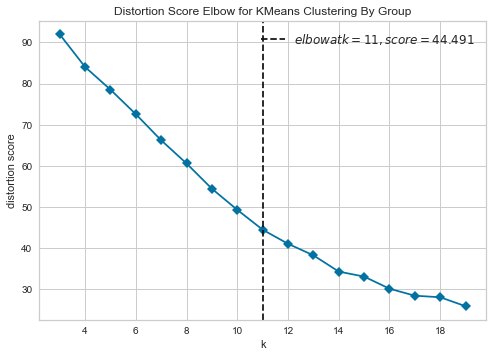

In [68]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
metric_val = 'distortion'
visualizer = KElbowVisualizer(model, k=(3,20),title="Distortion Score Elbow for KMeans Clustering By Group", metric=metric_val,timings=False)
# , metric='calinski_harabasz','silhouette'
visualizer.fit(dfw_grouped_clustering_bygroup)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bygroup.png")

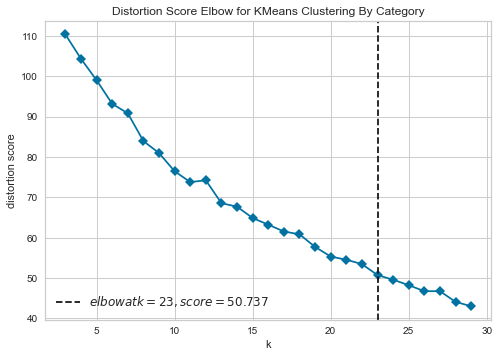

In [69]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,30),title="Distortion Score Elbow for KMeans Clustering By Category", metric=metric_val,timings=False)
visualizer.fit(dfw_grouped_clustering)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bycategory.png")